# Cambio 2.0

## In common between Cambio1 and Cambio2
The equations of motion in Cambio2.0 are the same as in Cambio1.0, shown below for convenience.

$$
F_{land->atm} =  k_{la} \ \ \ (1) 
$$

$$
F_{atm->land} = k_{al0} +  k_{al1} [C_{atm}] \ \ \ (2)
$$

$$
F_{ocean->atm} = k_{oa} [C_{ocean}] \ \ \ (3)
$$

$$
F_{atm->ocean} = k_{ao} [C_{atm}] \ \ \ (4)
$$

$$
F_{human->atm} = \epsilon(t) \ \ \ (5)
$$


## Differences between Cambio1 and Cambio2

You've already seen two differences:

- There's the *ClimateParams* dictionary that contains parametric variables. The cell that creates that dictionary is repeated here so you can modify it. 
- There are a bunch of *diagnostic functions* that derive time-dependent diagnostic climate variables. These include, for example, a function that calculates the pH value of the ocean surface, based on the amount of carbon in the air. Here's a complete list of them:

    Diagnose_OceanSurfacepH  
    Diagnose_T_anomaly  
    Diagnose_actual_temperature  
    Diagnose_degreesF  
    Diagnose_F_ao  
    Diagnose_F_oa  
    Diagnose_F_al  
    Diagnose_albedo  
    Diagnose_Delta_T_from_albedo  
    Diagnose_Stochastic_C_atm  

These functions have been moved to our usual resources library, *Conn350Lib*, for your convenience. Here we're importing them in the usual way, so that a "CL." prefix is needed to use them. If you need a reminder about their arguments, you can use Python's *help* command (an example is shown below). 

Other differences are

- There's another dictionary, called *ClimateState*, that will contain variables that define the current state of the climate. These will include prognostic variables, like the amounts of carbon in the atmosphere and ocean reservoirs, but also diagnostic and even a few parametric variables.
- There's a new *propagate function*, whose job it is to move the state of the climate from one time step to the next.
- We've also introduced a *list* of ClimateState dictionaries -- basically, this is the model as it changes over time.


## Tiered dependencies among diagnostic variables

It's worth elaborating a bit on exactly how dependencies work within a climate model. For example, in our Euler loop, we use the concentration of carbon in the atmosphere (a prognostic variable) to compute ocean $pH$ and the temperature anomaly:

    pH = CL.Diagnose_OceanSurfacepH(C_atm, ClimateParams)
    T_anomaly = CL.Diagnose_T_anomaly(C_atm, ClimateParams)

Because $pH$ and $T_{anomaly}$ are derived directly from a prognostic variable, we'll call them *tier 1* diagnostics. After that, we have a *tier 2* diagnostic, 

    albedo = CL.Diagnose_albedo(T_anomaly, ClimateParams)

so-named because $\alpha$ depends on the *tier 1* variable $T_{anomaly}$. And so on. 

How is this line of thinking useful? It's because it helps us predict the conversion from diagnostic to prognostic status. More precisely, if you make a change in your code such that a tiered variable affects a prognostic variable, then not only is *it* converted from diagnostic to prognostic (the "loop" is closed, so to speak), so are  the variables in lower-numbered tiers!


## Learning goals

1. I can use Python's "help" command to query functions in library.
1. I understand what it means to create a climate state as a dictionary.
1. I know how to arrange diagnostic variables in tiers, and how to use that structure to predict which will be converted to prognostic status after a change is made. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5io
import Conn350Lib as CL
from copy import copy as makeacopy

In [2]:
%matplotlib notebook

### The ClimateParams dictionary
The cell below creates a dictionary of climate parameters. You should modify the name of the ScheduledFlows file so that it picks up the file you want to work with. 

In [3]:
# Start with an empty dictionary
ClimateParams = {}

# Preindustrial climate values
ClimateParams['preindust_C_atm'] = 615
ClimateParams['preindust_C_ocean'] = 350
ClimateParams['preindust_albedo'] = 0.3
ClimateParams['preindust_pH'] = 8.2

# Parameter for the basic sensitivity of the climate to increasing CO2
ClimateParams['climate_sensitivity'] = 3/ClimateParams['preindust_C_atm'] # IPCC: 3 degrees for doubled CO2

# Carbon flux constants
ClimateParams['k_la'] = 120
ClimateParams['k_al0'] = 113
ClimateParams['k_al1'] = 0.0114
ClimateParams['k_oa'] = 0.2
ClimateParams['k_ao'] = 0.114

# Parameter for the ocean degassing flux feedback
ClimateParams['DC'] = 0.034 # Pretty well known from physical chemistry

# Parameters for albedo feedback
ClimateParams['albedo_sensitivity'] = -100 # Based on our radiative balance sensitivity analysis
ClimateParams['albedo_transition_temperature'] = 3 # A guess at the T at which significant albedo reduction kicks in
ClimateParams['albedo_transition_interval'] = 1 # Also a guess: Over what temperature range will albedo reduction kick in?
ClimateParams['max_albedo_change_rate'] = 0.0005 # Also a guess, this controls how fast albedo can change in a year
ClimateParams['fractional_albedo_floor'] = 0.9 # Also a guess: .9 would be a 10% maximum reduction in albedo

# Parameters for the atmosphere->land flux feedback
ClimateParams['F_al_transitionT'] = 2 # Pretty much a guess: at what T will photosynthesis be impaired?
ClimateParams['F_al_transitionTinterval'] = 1 # Also a guess
ClimateParams['fractional_F_al_floor'] = 0.9 # Also a guess: .9 would be a 10% maximum reduction in F_al

# Parameter for stochastic processes
ClimateParams['Stochastic_C_atm_std_dev'] = 3

# Name of your scheduled flows file
### BEGIN SOLUTION
ClimateParams['ScheduledFlowsFile'] = '../Week_05a.ScheduledFlows/Peaks_in_2030.hdf5'
# ClimateParams['ScheduledFlowsFile'] = 'Peaks_in_2030.hdf5'
### END SOLUTION

# This displays the dictionary contents
display(ClimateParams)

{'preindust_C_atm': 615,
 'preindust_C_ocean': 350,
 'preindust_albedo': 0.3,
 'preindust_pH': 8.2,
 'climate_sensitivity': 0.004878048780487805,
 'k_la': 120,
 'k_al0': 113,
 'k_al1': 0.0114,
 'k_oa': 0.2,
 'k_ao': 0.114,
 'DC': 0.034,
 'albedo_sensitivity': -100,
 'albedo_transition_temperature': 3,
 'albedo_transition_interval': 1,
 'max_albedo_change_rate': 0.0005,
 'fractional_albedo_floor': 0.9,
 'F_al_transitionT': 2,
 'F_al_transitionTinterval': 1,
 'fractional_F_al_floor': 0.9,
 'Stochastic_C_atm_std_dev': 3,
 'ScheduledFlowsFile': '../Week_05a.ScheduledFlows/Peaks_in_2030.hdf5'}

### Python's "help" command
The cell below shows how to get details about functions. Try it!

In [4]:
help(CL.Diagnose_OceanSurfacepH)
help(np.log10)

Help on function Diagnose_OceanSurfacepH in module Conn350Lib:

Diagnose_OceanSurfacepH(C_atm, ClimateParams)
    Computes ocean pH as a function of atmospheric CO2

Help on ufunc:

log10 = <ufunc 'log10'>
    log10(x, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature, extobj])
    
    Return the base 10 logarithm of the input array, element-wise.
    
    Parameters
    ----------
    x : array_like
        Input values.
    out : ndarray, None, or tuple of ndarray and None, optional
        A location into which the result is stored. If provided, it must have
        a shape that the inputs broadcast to. If not provided or None,
        a freshly-allocated array is returned. A tuple (possible only as a
        keyword argument) must have length equal to the number of outputs.
    where : array_like, optional
        This condition is broadcast over the input. At locations where the
        condition is True, the `out` array will be set to

### Your turn
Use Python's "help" command to get help on a couple of functions in the CL library (check out the list in the Introduction).

In [5]:
### BEGIN SOLUTION
help(CL.Diagnose_OceanSurfacepH)
help(CL.Diagnose_T_anomaly)
help(CL.Diagnose_indirect_T_anomaly)
help(CL.Diagnose_actual_temperature)
help(CL.Diagnose_degreesF)
help(CL.Diagnose_F_ao)
help(CL.Diagnose_F_oa)
help(CL.Diagnose_F_al)
help(CL.Diagnose_albedo)
help(CL.Diagnose_Delta_T_from_albedo)
help(CL.Diagnose_Stochastic_C_atm)
### END SOLUTION

Help on function Diagnose_OceanSurfacepH in module Conn350Lib:

Diagnose_OceanSurfacepH(C_atm, ClimateParams)
    Computes ocean pH as a function of atmospheric CO2

Help on function Diagnose_T_anomaly in module Conn350Lib:

Diagnose_T_anomaly(C_atm, ClimateParams)
    Computes a temperature anomaly from the atmospheric carbon amount

Help on function Diagnose_indirect_T_anomaly in module Conn350Lib:

Diagnose_indirect_T_anomaly(T_anomaly, albedo, ClimateParams)
    Computes a temperature anomaly resulting from a lower albedo

Help on function Diagnose_actual_temperature in module Conn350Lib:

Diagnose_actual_temperature(T_anomaly)
    Computes degrees C from a temperature anomaly

Help on function Diagnose_degreesF in module Conn350Lib:

Diagnose_degreesF(T_C)
    Converts temperature from C to F

Help on function Diagnose_F_ao in module Conn350Lib:

Diagnose_F_ao(C_atm, ClimateParams)
    Computes flux of carbon from atm to ocean

Help on function Diagnose_F_oa in module Conn350Lib:


### A function for creating a climate state
The function below returns a dictionary, ClimateState, using preindustrial values found in ClimateParams as defaults. 

In [6]:
def CreateClimateState(ClimateParams):
    """Creates a new climate state with preindustrial default values"""

    # Create an empty climate state
    ClimateState = {}

    # Fill in some default (preindustrial) values
    ClimateState['C_atm'] = ClimateParams['preindust_C_atm']
    ClimateState['C_ocean'] = ClimateParams['preindust_C_ocean']
    ClimateState['albedo'] = ClimateParams['preindust_albedo']
    ClimateState['T_anomaly'] = 0
    
    # These are just placeholders (values don't mean anything)
    ClimateState['pH'] = 0
    ClimateState['T_C'] = 0
    ClimateState['T_F'] = 0
    ClimateState['F_ha'] = 0
    ClimateState['F_ao'] = 0
    ClimateState['F_oa'] = 0
    ClimateState['F_al'] = 0
    ClimateState['F_la'] = 0
    
    # It's assumed we want time=0 (regardless of the actual year)
    ClimateState['time'] = 0

    # Return the climate
    return ClimateState

### Exercising CreateClimateState
The cell below uses CreateClimateState to create a climate state called *PreindustClimateState*, containing preindustrial parameters. The only customization is the calendar year for this state. Try it!

In [7]:
# Create a starting state -- the default is a preindustrial state
PreindustClimateState = CreateClimateState(ClimateParams)

# Add some (rather arbitrary) times
PreindustClimateState['year'] = 1880

# Display the state
display(PreindustClimateState)

{'C_atm': 615,
 'C_ocean': 350,
 'albedo': 0.3,
 'T_anomaly': 0,
 'pH': 0,
 'T_C': 0,
 'T_F': 0,
 'F_ha': 0,
 'F_ao': 0,
 'F_oa': 0,
 'F_al': 0,
 'F_la': 0,
 'time': 0,
 'year': 1880}

### Your turn: Create a modern climate state
Here' you'll craft a new state called *ModernClimateState*. To do that, use the method just exercised (CreateClimateState) to create a new climate state, then customize it as follows:

- Change the values of "C_atm" and "C_ocean" to 890 and 472, respectively
- Specify the year as 2018

In [8]:
# Create the state "ClimateState"
ModernClimateState = CreateClimateState(ClimateParams)

# Give it modern values for C_atm and C_ocean
### BEGIN SOLUTION
ModernClimateState['C_atm'] = 890
ModernClimateState['C_ocean'] = 472
### END SOLUTION

# Specify the year as 2018
### BEGIN SOLUTION
ModernClimateState['year'] = 2018
### END SOLUTION

# Display the state
### BEGIN SOLUTION
display(ModernClimateState)
### END SOLUTION

{'C_atm': 890,
 'C_ocean': 472,
 'albedo': 0.3,
 'T_anomaly': 0,
 'pH': 0,
 'T_C': 0,
 'T_F': 0,
 'F_ha': 0,
 'F_ao': 0,
 'F_oa': 0,
 'F_al': 0,
 'F_la': 0,
 'time': 0,
 'year': 2018}

### Making a list of climate states
Eventually, we're going to want to make list of climate states. In the next cell, we practice that process by making a very simple list, consisting of the preindustrial and modern states (dictionaries) we just made. 

You might notice that the syntax for this is different from how we appended to make lists before. That's because here we're creating a regular Python list, whereas before we were creating a list of numpy arrays.

In [9]:
ClimateState_list = []
ClimateState_list.append(PreindustClimateState)
ClimateState_list.append(ModernClimateState)
display(ClimateState_list)

[{'C_atm': 615,
  'C_ocean': 350,
  'albedo': 0.3,
  'T_anomaly': 0,
  'pH': 0,
  'T_C': 0,
  'T_F': 0,
  'F_ha': 0,
  'F_ao': 0,
  'F_oa': 0,
  'F_al': 0,
  'F_la': 0,
  'time': 0,
  'year': 1880},
 {'C_atm': 890,
  'C_ocean': 472,
  'albedo': 0.3,
  'T_anomaly': 0,
  'pH': 0,
  'T_C': 0,
  'T_F': 0,
  'F_ha': 0,
  'F_ao': 0,
  'F_oa': 0,
  'F_al': 0,
  'F_la': 0,
  'time': 0,
  'year': 2018}]

### Extracting a time series from a climate list
The "display" capability we just used is handy to get a view of the contents of a list, but sometimes we're more interested in particular items in the list. The function CollectClimateTimeSeries does just that. In the cell below, you can see how this works; of course there are just two values, but when you use CollectClimateTimeSeries  later, there will be a lot more values.

In [10]:
year_array = CL.CollectClimateTimeSeries(ClimateState_list,'year')
print(year_array)

[1880. 2018.]


### Your turn
Collect and print all the atmospheric reservoir carbon amounts in ClimateState_list.

In [11]:
### BEGIN SOLUTION
C_atm_array = CL.CollectClimateTimeSeries(ClimateState_list,'C_atm')
print(C_atm_array)
### END SOLUTION

[615. 890.]


### Propagating through time
The cell below defines a function whose job is to propagate the climate state forward one time step. This is all done for you, but it's worth taking a few minutes to inspect the code so you understand how the tiering works, since eventually you'll be modifying this function to implement feedbacks. 

In [12]:
def PropagateClimateState(previousClimateState, ClimateParams, dtime=1, F_ha=0):
    """Propagates the state of the climate, with a specified anthropogenic carbon flux"""
    """Default anthropogenic carbon flux is zero"""
    """Default time step is 1 year"""
    """Returns a new climate state"""

    # Extract concentrations from the previous climate state
    C_atm = previousClimateState['C_atm']
    C_ocean = previousClimateState['C_ocean']
    
    # Get new fluxes -- assuming zeros for temperature anomaly
    F_oa = CL.Diagnose_F_oa(C_ocean, 0, ClimateParams) # We're assuming T_anomaly=0 here
    F_ao = CL.Diagnose_F_ao(C_atm, ClimateParams)
    F_la = CL.Diagnose_F_la(ClimateParams)
    F_al = CL.Diagnose_F_al(0, C_atm, ClimateParams) # We're assuming T_anomaly=0 here

    # Get new concentrations of carbon that depend on the fluxes
    C_atm += (F_la + F_oa - F_ao - F_al + F_ha)*dtime
    C_ocean += (F_ao - F_oa)*dtime
    
    # Tier 1 diagnostics (depend on C_atm and parametric variables)
    pH = CL.Diagnose_OceanSurfacepH(C_atm, ClimateParams)
    T_anomaly = CL.Diagnose_T_anomaly(C_atm, ClimateParams)
    
    # Tier 2 diagnostics (depend on tier-1 diagnostic variables)
    albedo = CL.Diagnose_albedo(T_anomaly, ClimateParams)
    
    # Tier 3 diagnostics (depends on tier-2 diagnostic variables) 
    T_anomaly = CL.Diagnose_indirect_T_anomaly(T_anomaly, albedo, ClimateParams)
    
    # Tier 4 diagnostics
    T_C = CL.Diagnose_actual_temperature(T_anomaly)
    T_F = CL.Diagnose_degreesF(T_C)

    # Create a new climate state with these updates
    ClimateState = makeacopy(previousClimateState)
    ClimateState['C_atm'] = C_atm
    ClimateState['C_ocean'] = C_ocean
    ClimateState['F_oa'] = F_oa
    ClimateState['F_ao'] = F_ao
    ClimateState['F_la'] = F_la
    ClimateState['F_al'] = F_al
    ClimateState['time'] += dtime
    ClimateState['year'] += dtime
    ClimateState['F_ha'] = F_ha
    ClimateState['T_anomaly'] = T_anomaly
    ClimateState['pH'] = pH
    ClimateState['T_C'] = T_C
    ClimateState['T_F'] = T_F
    ClimateState['albedo'] = albedo

    # Return the new climate state
    return ClimateState

### Testing the propagator
The cell below takes the propagator "out for a spin." The resulting new carbon amount in the atmosphere should be about 5 GtC higher.

In [13]:
# Testing the algorithm
NextClimateState = PropagateClimateState(ModernClimateState, ClimateParams, dtime=1, F_ha=15)
print('C_atm changed by', NextClimateState['C_atm']- ModernClimateState['C_atm'])

C_atm changed by 4.7965087234547354


### Loading the scheduled flow
In the cell below we load the scheduled flow file we specified above. The function that does this, CL.GetMyScenario, will also do some reporting and plotting, if you set the flags to "True".

Here's the scenario summary:


{'dataframe':             time     emissions
 0     1750.00000  1.582627e-02
 1     1750.10002  1.586589e-02
 2     1750.20004  1.590561e-02
 3     1750.30006  1.594543e-02
 4     1750.40008  1.598536e-02
 ...          ...           ...
 4995  2249.59992  9.335894e-11
 4996  2249.69994  9.172082e-11
 4997  2249.79996  9.101219e-11
 4998  2249.89998  8.935881e-11
 4999  2250.00000  8.863956e-11
 
 [5000 rows x 2 columns],
 'delta_t_trans': 20,
 'emission units': 'GtC/year',
 'eps_0': 12.4,
 'k': 0.025,
 't_0': 2018,
 't_trans': 2040}

<IPython.core.display.Javascript object>


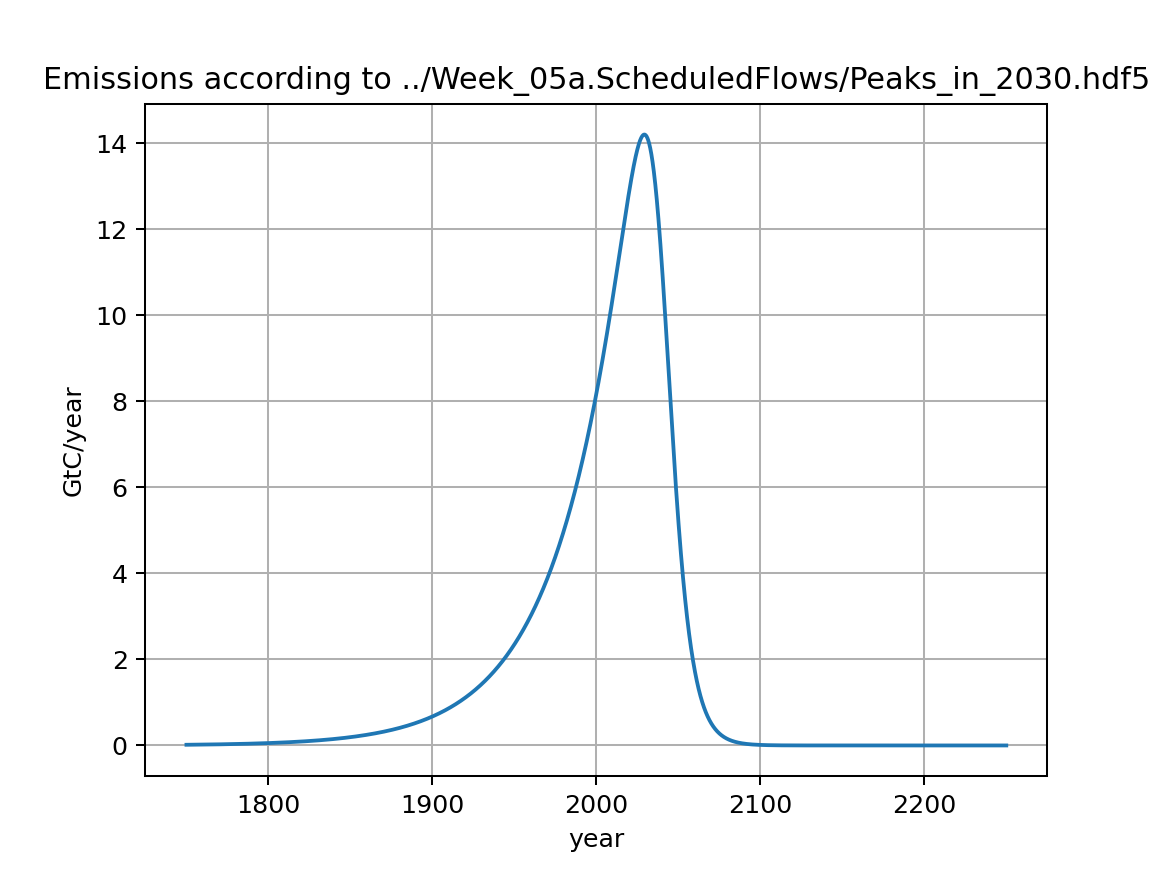

In [14]:
# Here's loading it in with reporting, but no graphics
time, eps = CL.GetMyScenario(ClimateParams['ScheduledFlowsFile'],reportflag=True,plotflag=False)

# Load it in with graphics, but no reporting
### BEGIN SOLUTION
time, eps = CL.GetMyScenario(ClimateParams['ScheduledFlowsFile'],reportflag=False,plotflag=True)
### END SOLUTION

### Running the model
This is all done for you, but it's worth taking a few minutes to inspect the code so you understand what it's doing. 

In [15]:
# Initialize our list of climate states
ClimateState_list = []

# Make the starting state the preindustrial
ClimateState = CreateClimateState(ClimateParams)

# Add some times
ClimateState['year'] = time[0] # This sets the starting year the same as the scheduled flow 
dt = time[1]-time[0]

# Loop over all the times in the scheduled flow
for i in range(len(time)):

    # Propagate
    ClimateState = PropagateClimateState(ClimateState,ClimateParams,dtime=dt,F_ha=eps[i])
    
    # Add to our list of climate states
    ClimateState_list.append(ClimateState)


### Visualizing the results of the run
Use CL.CollectClimateTimeSeries in the cell below to collect various time series. Then you'll be plotting them as a function of the year.

<IPython.core.display.Javascript object>


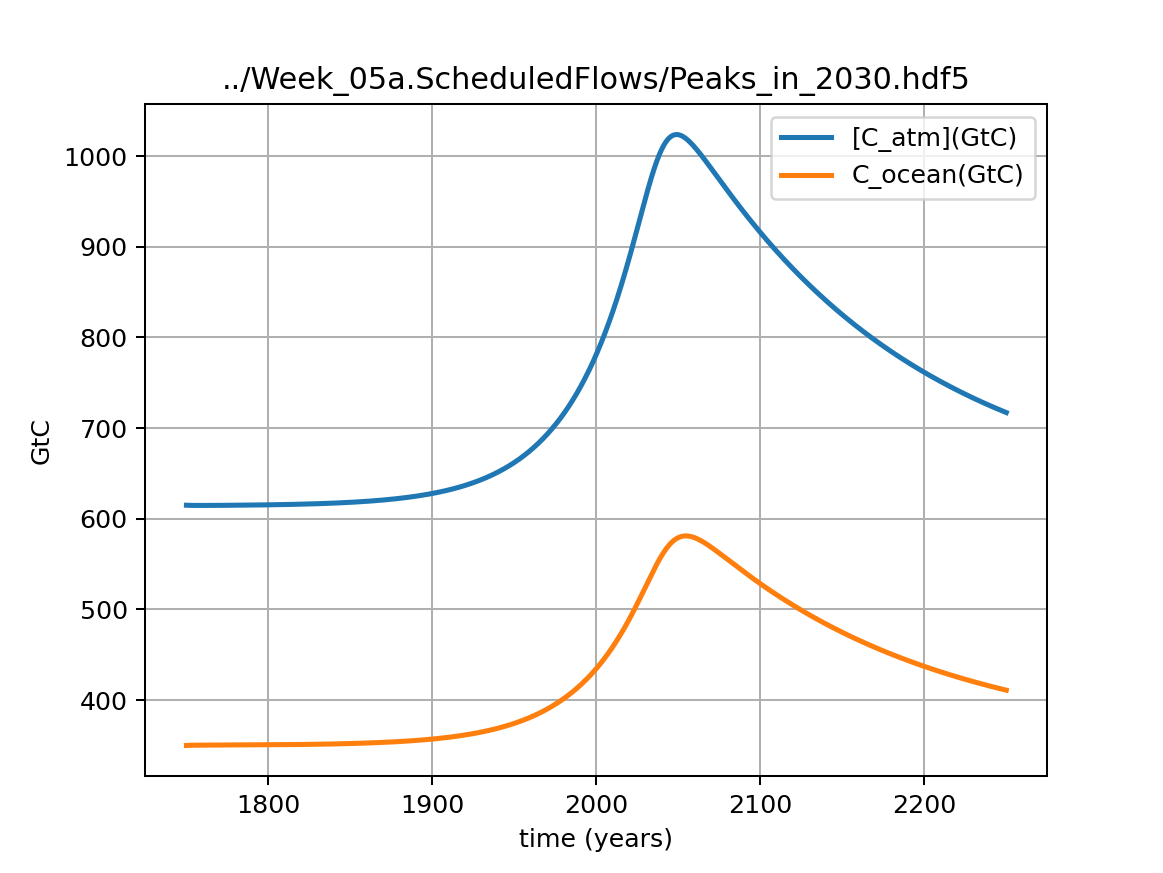

<IPython.core.display.Javascript object>


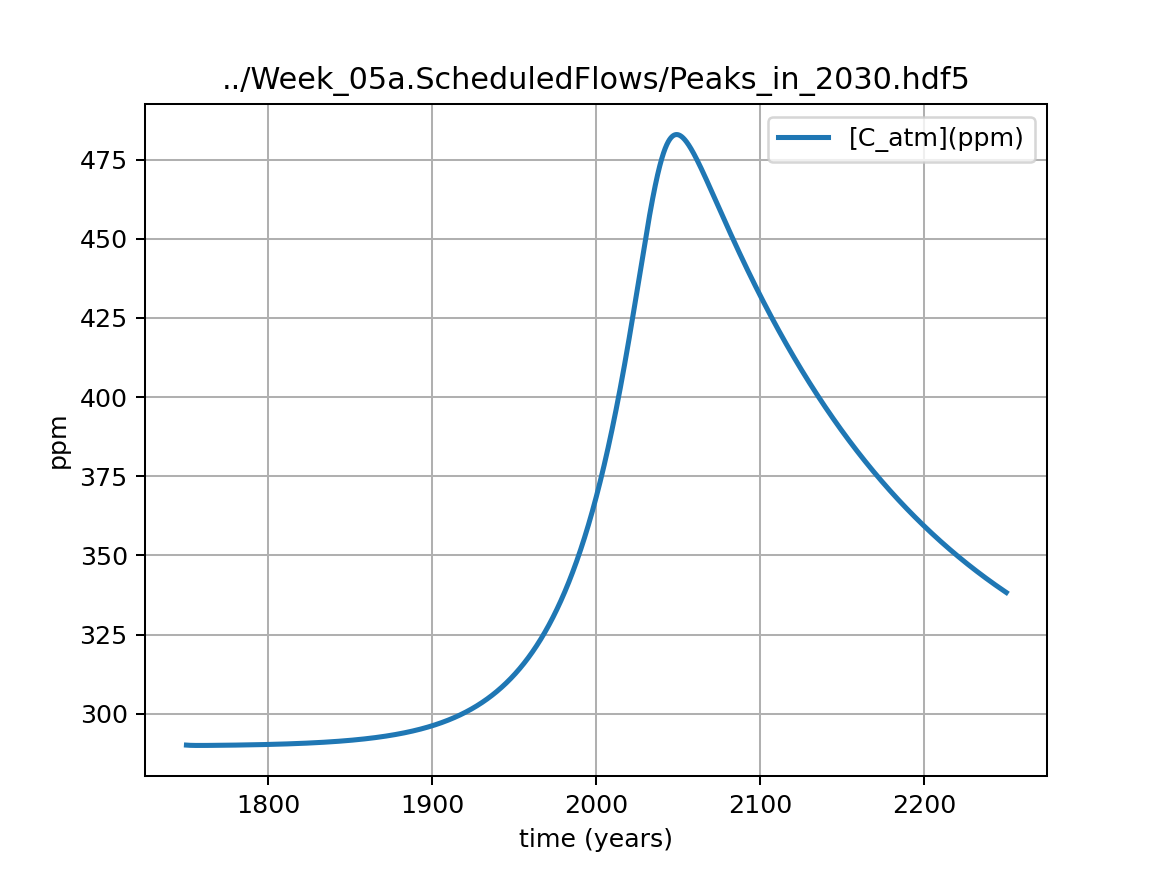

<IPython.core.display.Javascript object>


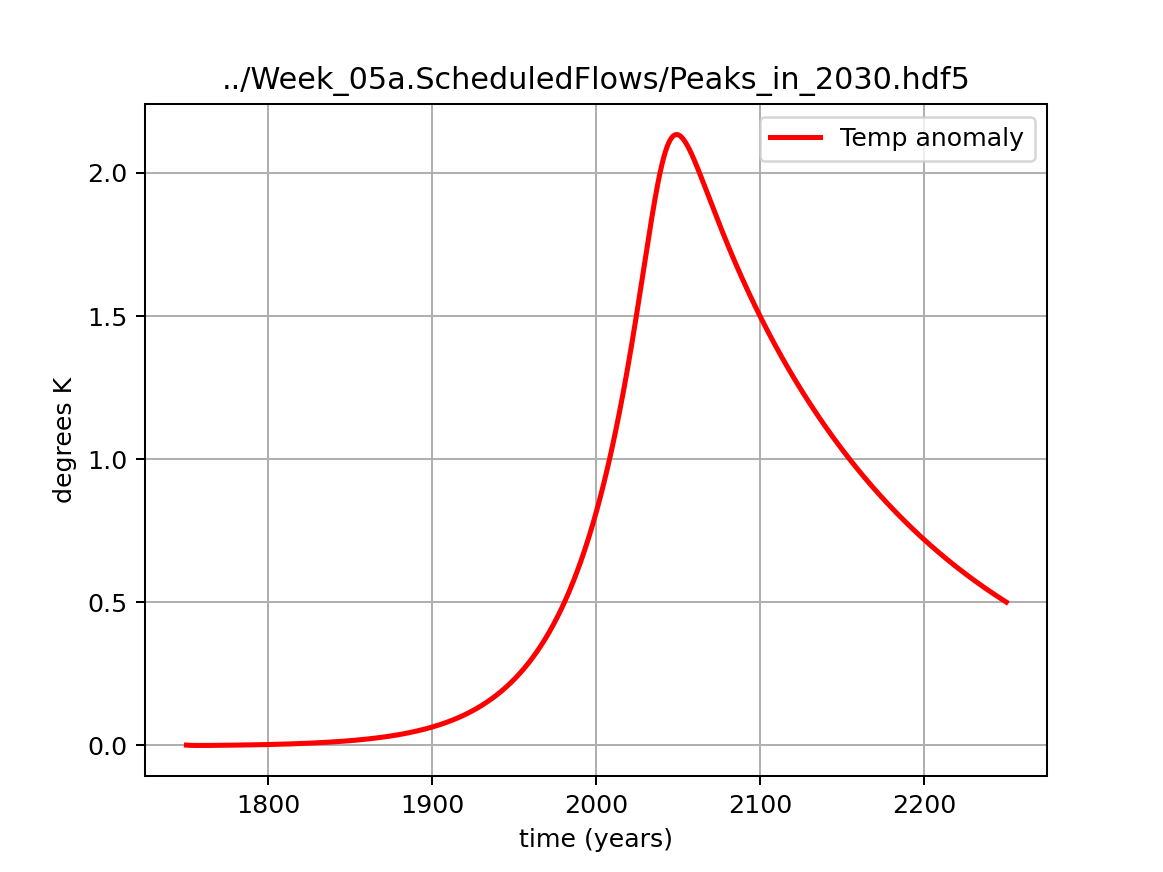

<IPython.core.display.Javascript object>


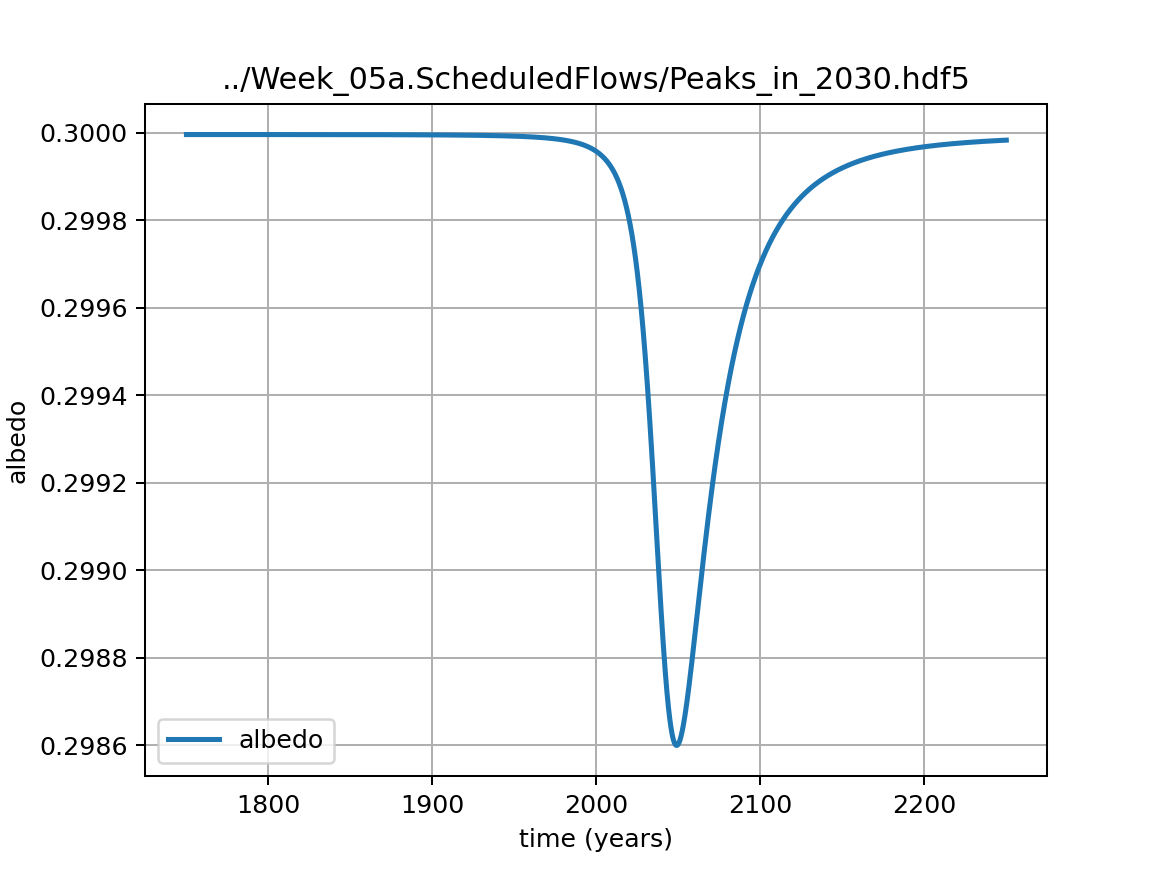

<IPython.core.display.Javascript object>


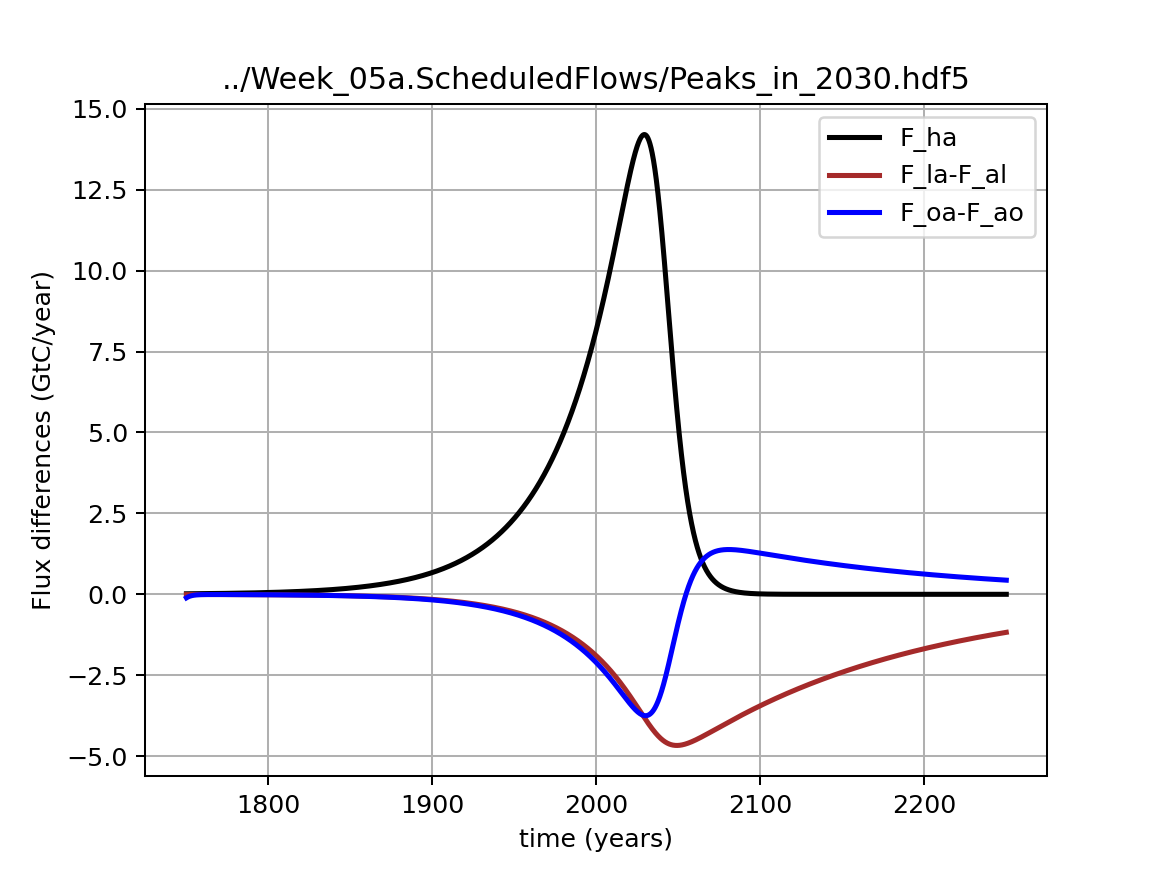

Text(0.5, 1.0, '../Week_05a.ScheduledFlows/Peaks_in_2030.hdf5')

In [16]:
# Here we are extracting the times from ClimateState_list
time = CL.CollectClimateTimeSeries(ClimateState_list,'year')

# Extract the concentration of carbon in the atmosphere & oceans
### BEGIN SOLUTION
C_atm_array = CL.CollectClimateTimeSeries(ClimateState_list,'C_atm')
C_ocean_array = CL.CollectClimateTimeSeries(ClimateState_list,'C_ocean')
### END SOLUTION

# Now plot the concentration of carbon in the atmosphere & oceans
### BEGIN SOLUTION
linewidth = 2
plt.figure()
plt.plot(time,C_atm_array,label='[C_atm](GtC)',linewidth=linewidth)
plt.plot(time,C_ocean_array,label='C_ocean(GtC)',linewidth=linewidth)
plt.grid(True)
plt.xlabel('time (years)')
plt.ylabel("GtC")
plt.legend()
plt.title(ClimateParams['ScheduledFlowsFile'])
### END SOLUTION

# Re-plot the carbon in the atmosphere, converted to ppm
### BEGIN SOLUTION
plt.figure()
plt.plot(time,C_atm_array/2.12,label='[C_atm](ppm)',linewidth=linewidth)
plt.grid(True)
plt.xlabel('time (years)')
plt.ylabel("ppm")
plt.legend()
plt.title(ClimateParams['ScheduledFlowsFile'])
### END SOLUTION

# Extract and plot the temperature
### BEGIN SOLUTION
T_array = CL.CollectClimateTimeSeries(ClimateState_list,'T_anomaly')
plt.figure()
plt.plot(time,T_array,label='Temp anomaly',linewidth=linewidth,color='red')
plt.grid(True)
plt.xlabel('time (years)')
plt.ylabel("degrees K")
plt.legend()
plt.title(ClimateParams['ScheduledFlowsFile'])
### END SOLUTION

# Extract and plot the albedo
### BEGIN SOLUTION
albedo_array = CL.CollectClimateTimeSeries(ClimateState_list,'albedo')
plt.figure()
plt.plot(time,albedo_array,label='albedo',linewidth=linewidth)
plt.grid(True)
plt.xlabel('time (years)')
plt.ylabel("albedo")
plt.legend()
plt.title(ClimateParams['ScheduledFlowsFile'])
### END SOLUTION

# Extract the fluxes, compute net fluxes, and plot them
### BEGIN SOLUTION
F_al_array = CL.CollectClimateTimeSeries(ClimateState_list,'F_al')
F_la_array = CL.CollectClimateTimeSeries(ClimateState_list,'F_la')
F_ao_array = CL.CollectClimateTimeSeries(ClimateState_list,'F_ao')
F_oa_array = CL.CollectClimateTimeSeries(ClimateState_list,'F_oa')
F_ha_array = CL.CollectClimateTimeSeries(ClimateState_list,'F_ha')
plt.figure()
# fontsize=12
# plt.rcParams.update({'font.size': fontsize})
plt.plot(time,F_ha_array,label='F_ha',color='black',linewidth=linewidth)
plt.plot(time,-F_al_array+F_la_array,label='F_la-F_al',color='brown',linewidth=linewidth)
plt.plot(time,-F_ao_array+F_oa_array,label='F_oa-F_ao',color='blue',linewidth=linewidth)
plt.grid(True)
plt.xlabel('time (years)')
plt.ylabel("Flux differences (GtC/year)")
plt.legend()
plt.title(ClimateParams['ScheduledFlowsFile'])
### END SOLUTION

### Refresh/save/validate
Double-check everything is OK, and press the "Validate" button (as usual).

### Close/submit/logout
Close, submit, and log out.